## IIIa- Image processing

### Image exploration

I start by creating Label-specific dataframes to have a first look at the fundi based on the diagnostic they have been assigned. 

1) image exploration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2
import os, glob
import imageio
import skimage.io
import skimage.exposure

df=pd.read_csv('dataframe_ODIR.csv')
df.head()

,Unnamed: 0,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,N,D,G,C,A,M,H,O,Labels
0,0,0,69,Female,0_left.jpg,cataract,0,0,0,1,0,0,0,0,Cataract
1,0,0,69,Female,0_right.jpg,normal fundus,1,0,0,0,0,0,0,0,Normal
2,1,1,57,Male,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0,Normal
3,1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,Normal
4,2,2,42,Male,2_left.jpg,laser spot,0,0,0,0,0,0,0,1,Others


In [2]:
df_N = df.loc[(df.N==1)&(df.Labels=='Normal')].sample(8).reset_index()
df_C = df.loc[(df.C==1)&(df.Labels=='Cataract')].sample(8).reset_index()
df_M = df.loc[(df.M==1)&(df.Labels=='Myopia')].sample(8).reset_index()
df_H = df.loc[(df.H==1)&(df.Labels=='Hypertension')].sample(8).reset_index()
df_G = df.loc[(df.G==1)&(df.Labels=='Glaucoma')].sample(8).reset_index()
df_A = df.loc[(df.A==1)&(df.Labels=='AMD')].sample(8).reset_index()

IMAGE_PATH = "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/1-ODIR-5K_Training_Dataset"

In [3]:
def show_images(df, title="Labels", eye_exam="Fundus"):
    print(f"{title}")
    f, ax = plt.subplots(2,4,figsize=(12,6))
    f.subplots_adjust(hspace=0.02,wspace=0.02)
    for i,idx in enumerate(df.index):
        dd = df.iloc[idx]
        image_name = dd[eye_exam]
        image_path = os.path.join(IMAGE_PATH, image_name)
        img_data=imageio.imread(image_path)
        ax[i//4, i%4].imshow(img_data)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title(image_name)
    plt.show()

 A. DIAGNOSTIC : NORMAL



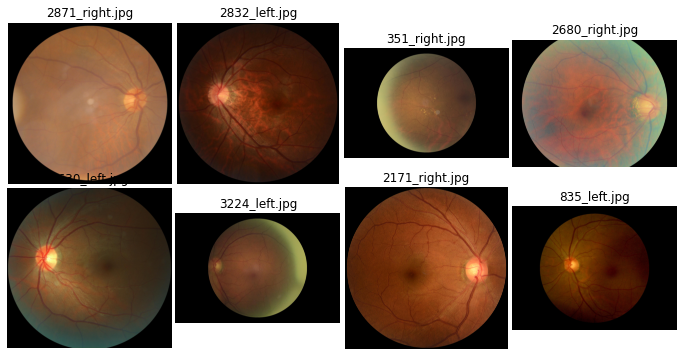

In [4]:
show_images(df_N,title="\033[1m A. DIAGNOSTIC : NORMAL\n\033[0m")

 B. DIAGNOSTIC : CATARACT



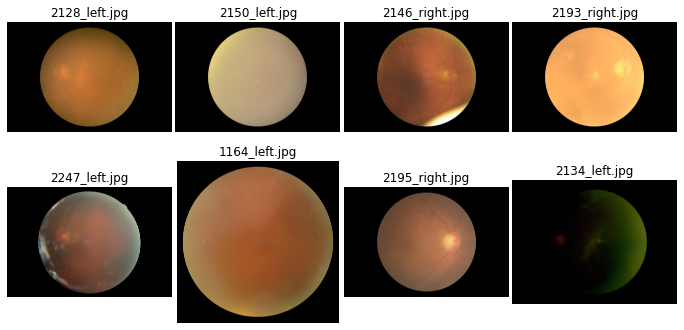

In [5]:
show_images(df_C,title="\033[1m B. DIAGNOSTIC : CATARACT\n\033[0m")

 C. DIAGNOSTIC : MYOPIA



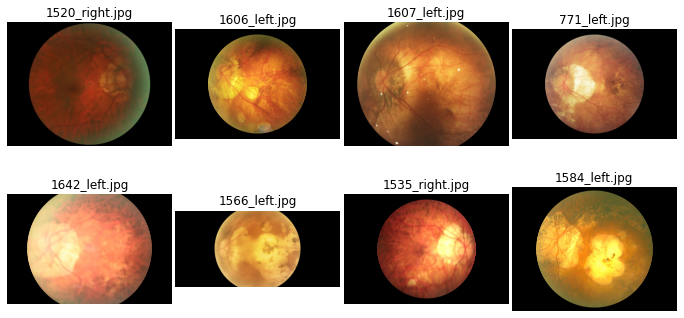

In [6]:
show_images(df_M,title="\033[1m C. DIAGNOSTIC : MYOPIA\n\033[0m")

 D. DIAGNOSTIC : HYPERTENSION



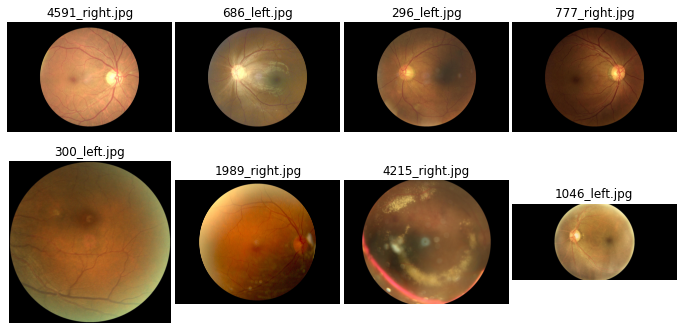

In [7]:
show_images(df_H,title="\033[1m D. DIAGNOSTIC : HYPERTENSION\n\033[0m")

Based on the images above we can note that : 
1) all fundi  are made of a round image which background corresponds to the retina, on the external side of which (whether right or left depending on the fundus) there is zone of emergence of the blood vessels (called the "optic disc", where the optic nerve is). 
2) blood vessels divides into upward and downward branches which then run towards the central side on the retina.  

Interestingly, this first observation also reveals that some diseases show a specific pattern. For instance, :
- cataract-related fundi display blurry images with no visible vessels nor details of the retina due to the opacification/clouding of the intraocular crystalline lens,
-  myopia-related fundi show an heterogenous background with large bright plaques due to the choroidal thinning of the retina that follows myopic-related changes in the shape of the eyeball.
<i>(See README.md for further information on the diseases)</i>
    
However, for some other diseases, differences are harder to identify for a non-expert eye when compared to "Normal" fundi (e.g. hypertension-related fundi).

<i>--> This observation means that to discriminate 2 diseases apart, our model might need to be able to analyze specific areas of the fundus. This tends to indicate that the image processing will be a project on its own using image segmentation. However, with no experience yet on image segmentation, I will not address this part of the process here.</i>  

Finally, we can see that the brightness, contrast, size, shape and quality of the images may differ from one fundus to another. 

Below I process the images in order to address this issue. 

### Image enhancement

Below I define some functions to center all fundi by cropping out the black background and only keep the circle-shaped area of the image. 
I will also try to equalize the images to adjust the contrast by looking at the intensity distribution of each fundi based on the intesity values of its pixels. 

In [8]:
def center_crop(img, dim):
    width, height = img.shape[1], img.shape[0]
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img

In [9]:
def equalize(img):
    # process crop width and height for max available dimension
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(gray)
    result = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
    return result

I then define a function to process the images by :
- centering each fundus and cropping out its background,
- equalizing it,
- resizing it.

Images are then displayed with and without equalization to see whether the equalization allows for a good enhancement in their quality when compared to the original fundi. 

In [10]:
def compare_process_image(df, title="Labels", eye_exam="Fundus"):
    print(f"{title}")
    f, ax = plt.subplots(2,6,figsize=(15,5))
    subfigs = f.subfigures(1, 3, wspace=0.07, width_ratios=[1, 1, 1])
    axs0 = subfigs[0].subplots(2,2)
    axs1 = subfigs[1].subplots(2,2)
    axs2 = subfigs[2].subplots(2,2)
    subfigs[0].set_facecolor('0.9')
    subfigs[1].set_facecolor('1')
    subfigs[2].set_facecolor('1')
    subfigs[0].supxlabel('Original pictures')
    subfigs[1].supxlabel('Processed pictures')
    subfigs[2].supxlabel('Equalized pictures')
    for i,idx in enumerate(df.index):
        dd = df.iloc[idx]
        image_name = dd[eye_exam]
        image_path = os.path.join(IMAGE_PATH, image_name)
        img_data=imageio.imread(image_path)
        # Remove Background (adapted from source : https://stackoverflow.com/questions/63526621/remove-background-from-image-python):
        gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 2, 255, cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        morph = cv2.morphologyEx(morph, cv2.MORPH_ERODE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)
        contour = np.zeros_like(gray)
        cv2.drawContours(contour, [big_contour], 0, 255, -1)
        blur = cv2.GaussianBlur(contour, (5,5), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)
        mask = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))
        result = cv2.cvtColor(img_data, cv2.COLOR_BGR2BGRA)
        result[:,:,3] = mask
        # Crop images: 
        h, w, *_ = result.shape
        cropped_img = center_crop(result, [h,w])
        # Equalize:
        eql=equalize(cropped_img)
        # Resize:
        dsize = (224,224)
        resized = cv2.resize(cropped_img, dsize)
        resized_eql = cv2.resize(eql, dsize)
        #Plot all processed images:   
        axs0[i//2, i%2].imshow(img_data)
        axs0[i//2, i%2].axis('off')
        axs0[i//2, i%2].set_title(image_name)
        axs1[i//2, i%2].imshow(resized)
        axs1[i//2, i%2].axis('off')
        axs1[i//2, i%2].set_title(image_name)
        axs2[i//2, i%2].imshow(resized_eql)
        axs2[i//2, i%2].axis('off')
        axs2[i//2, i%2].set_title(image_name)
    # Show:
    plt.show()

 A. DIAGNOSTIC : NORMAL



IndexError: index 2 is out of bounds for axis 0 with size 2

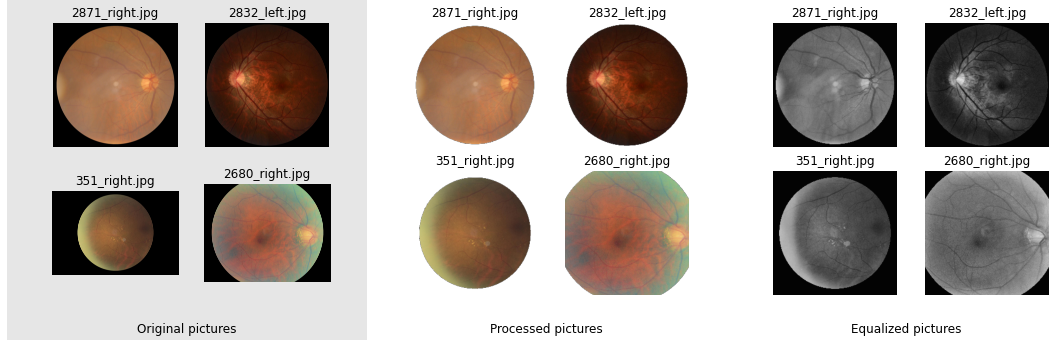

In [11]:
compare_process_image(df_N,title="\033[1m A. DIAGNOSTIC : NORMAL\n\033[0m")

 B. DIAGNOSTIC : CATARACT



IndexError: index 2 is out of bounds for axis 0 with size 2

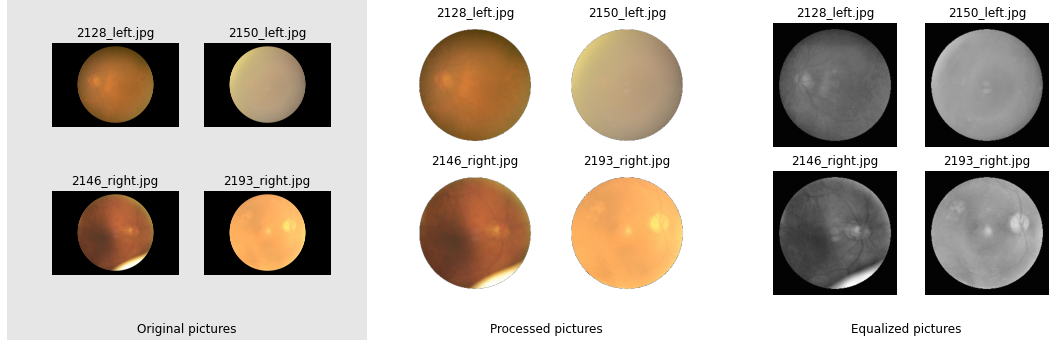

In [12]:
compare_process_image(df_C,title="\033[1m B. DIAGNOSTIC : CATARACT\n\033[0m")

 C. DIAGNOSTIC : MYOPIA



IndexError: index 2 is out of bounds for axis 0 with size 2

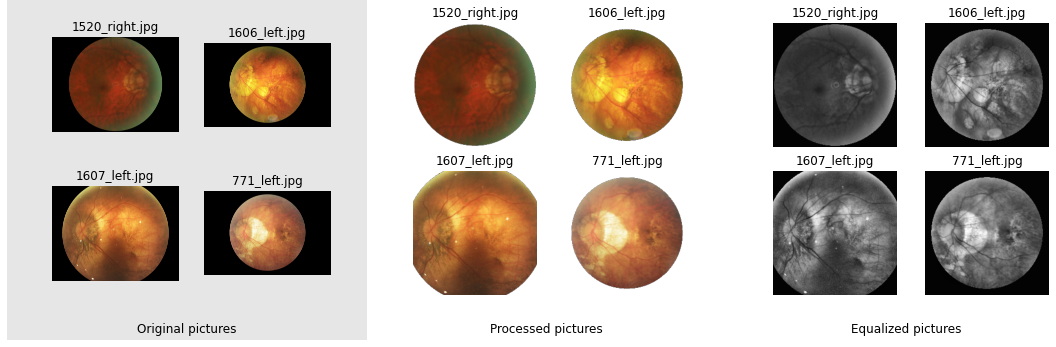

In [13]:
compare_process_image(df_M,title="\033[1m C. DIAGNOSTIC : MYOPIA\n\033[0m")

 D. DIAGNOSTIC : HYPERTENSION



IndexError: index 2 is out of bounds for axis 0 with size 2

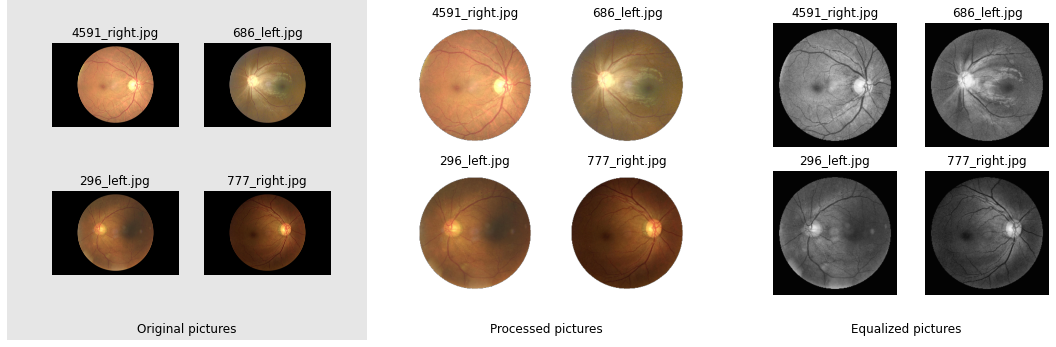

In [14]:
compare_process_image(df_H,title="\033[1m D. DIAGNOSTIC : HYPERTENSION\n\033[0m")

 F. DIAGNOSTIC : AMD



IndexError: index 2 is out of bounds for axis 0 with size 2

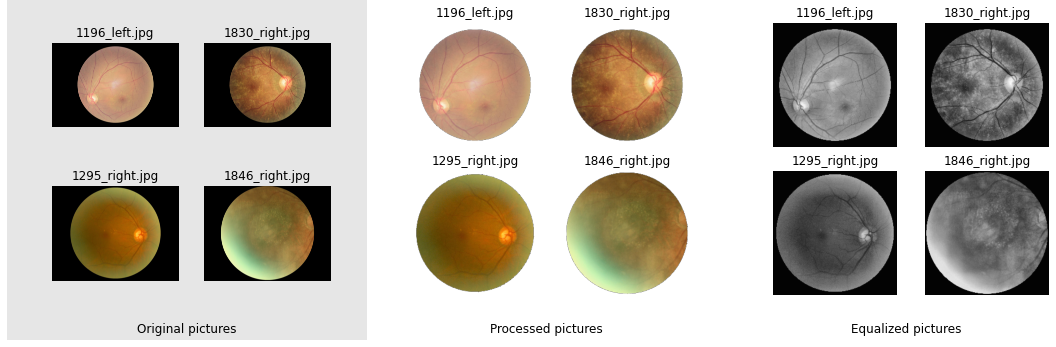

In [15]:
compare_process_image(df_A,title="\033[1m F. DIAGNOSTIC : AMD\n\033[0m")

 E. DIAGNOSTIC : GLAUCOMA



IndexError: index 2 is out of bounds for axis 0 with size 2

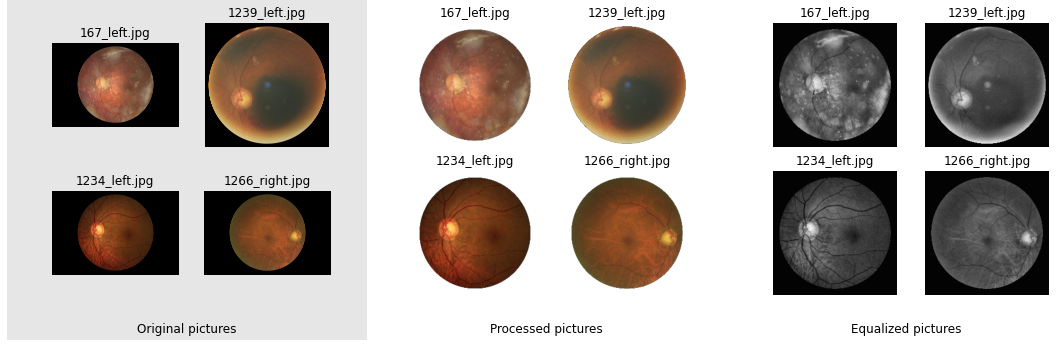

In [16]:
compare_process_image(df_G,title="\033[1m E. DIAGNOSTIC : GLAUCOMA\n\033[0m")

### Processing and saving the images

Below are the functions to proceed with the image processing of the dataset using the parameters tested above.

In [21]:
img_paths = []
for top,dirs, files in os.walk("/Users/user/Desktop/Datascientest/Fil_rouge/"):
    for pics in files:
        if os.path.splitext(pics)[0] == '-left' or os.path.splitext(pics)[0]== '-right' in ['jpg']:
            img_paths.append(os.path.join(top,pics))

In [22]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(IMAGE_PATH):
        img = cv2.imread(os.path.join(IMAGE_PATH,filename))
        if img is not None:
            images.append(img)
    return images

In [23]:
def process_file(df, title="diagnosis", eye_exam="Fundus"):
    for i,idx in enumerate(df.index):
        dd = df.iloc[idx]
        image_name = dd[eye_exam]
        image_path = os.path.join(IMAGE_PATH, image_name)
        img_data=cv2.imread(image_path)
        # Remove Background :
        gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 2, 255, cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        morph = cv2.morphologyEx(morph, cv2.MORPH_ERODE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)
        contour = np.zeros_like(gray)
        cv2.drawContours(contour, [big_contour], 0, 255, -1)
        blur = cv2.GaussianBlur(contour, (5,5), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)
        mask = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))
        result = cv2.cvtColor(img_data, cv2.COLOR_BGR2BGRA)
        result[:,:,3] = mask
        # Crop images: 
        h, w, *_ = result.shape
        cropped_img = center_crop(result, [h,w])
        # Equalize :
        eql=equalize(cropped_img)
        # Resize :
        dsize = (224,224)
        #resized = cv2.resize(cropped_img, dsize) 
        resized_eql = cv2.resize(eql, dsize)
        # Save image :
        #cv2.imwrite(os.path.join(OUTPUT_IMAGE_PATH,image_name),resized)
        cv2.imwrite(os.path.join(OUTPUT_IMAGE_PATH,image_name),resized_eql)

In [27]:
IMAGE_PATH = "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/1-ODIR-5K_Training_Dataset"
OUTPUT_IMAGE_PATH= "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/2-ODIR-5K_Training_Processed"
#process_file(df)

In [25]:
IMAGE_PATH = "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/1-ODIR-5K_Training_Dataset"
OUTPUT_IMAGE_PATH= "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/2-ODIR-5K_Training_Processed_Equal"
process_file(df)

### Checking the processed images 

Below is the function to look at the images before and after processing

In [30]:
def compare_images(df, title="Labels", eye_exam="Fundus"):
    print(f"{title}")
    f, ax = plt.subplots(2,6,figsize=(12,6))
    subfigs = f.subfigures(1, 3, wspace=0.07, width_ratios=[1, 1, 1])
    axs0 = subfigs[0].subplots(2, 2)
    axs1 = subfigs[1].subplots(2,2)
    axs2 = subfigs[2].subplots(2,2)
    subfigs[0].set_facecolor('0.9')
    subfigs[1].set_facecolor('1')
    subfigs[2].set_facecolor('1')
    subfigs[0].supxlabel('Original pictures')
    subfigs[1].supxlabel('Processed pictures')
    subfigs[2].supxlabel('Equalized processed & pictures')
    for i,idx in enumerate(df.index):
        dd = df.iloc[idx]
        image_name = dd[eye_exam]
        image_path1 = os.path.join(IMAGE_PATH_BEFORE, image_name)
        img_data1=imageio.imread(image_path1)
        axs0[i//2, i%2].imshow(img_data1)
        axs0[i//2, i%2].axis('off')
        axs0[i//2, i%2].set_title(image_name)
        
        image_path2 = os.path.join(IMAGE_PATH_AFTER, image_name)
        img_data2=imageio.imread(image_path2)
        axs1[i//2, i%2].imshow(img_data2)
        axs1[i//2, i%2].axis('off')
        axs1[i//2, i%2].set_title(image_name)
        
        image_path3 = os.path.join(EQUAL_IMAGE_PATH_AFTER, image_name)
        img_data3=imageio.imread(image_path3)
        axs2[i//2, i%2].imshow(img_data3)
        axs2[i//2, i%2].axis('off')
        axs2[i//2, i%2].set_title(image_name)
        
        #image_path2 = os.path.join(IMAGE_PATH_AFTER, image_name)
        #img_data2=imageio.imread(image_path2)
        #axs1[i//2, i%2].imshow(img_data2)
        #axs1[i//2, i%2].axis('off')
        #axs0[i//2, i%2].set_title(image_name)
        #for i in range(4):
         #   axs0[0,0].imshow(img_data1[i])
        #axs1 = axs1.flatten()
    plt.show()

In [31]:
IMAGE_PATH_BEFORE = "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/1-ODIR-5K_Training_Dataset"
IMAGE_PATH_AFTER = "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/2-ODIR-5K_Training_Processed" 
EQUAL_IMAGE_PATH_AFTER = "/Users/user/Desktop/Datascientest/Fil_rouge/Images_file/2-ODIR-5K_Training_Processed_Equal"

 NORMAL :



IndexError: index 2 is out of bounds for axis 0 with size 2

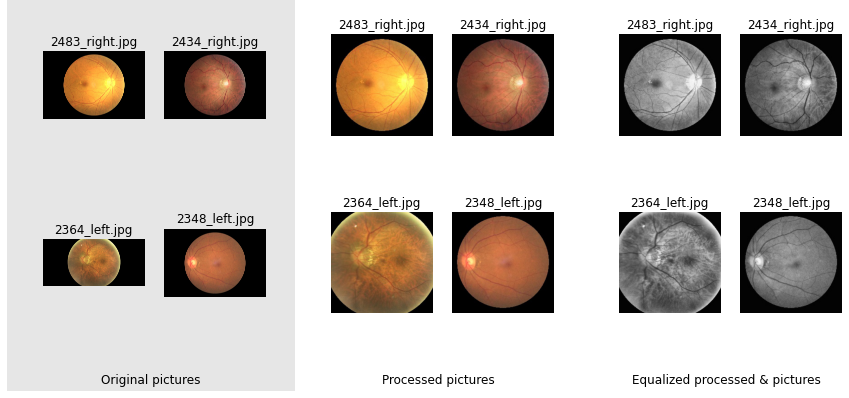

In [35]:
compare_images(df_N,title="\033[1m NORMAL :\n\033[0m")

 MYOPIA :



IndexError: index 2 is out of bounds for axis 0 with size 2

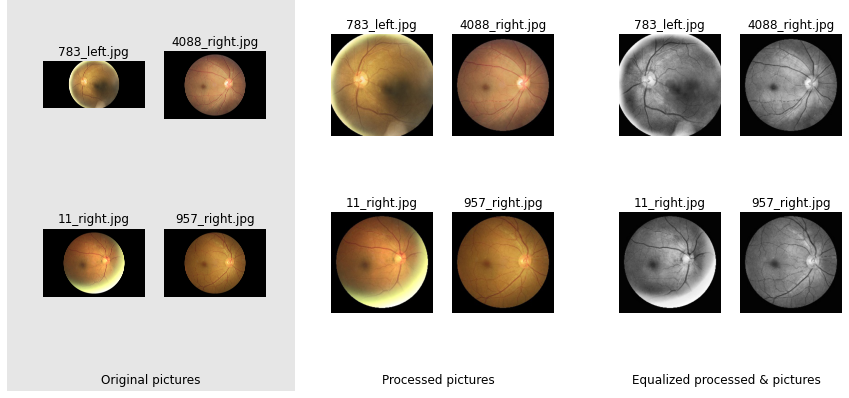

In [34]:
compare_images(df_H,title="\033[1m HYPERTENSION :\n\033[0m")

 GLAUCOMA :



IndexError: index 2 is out of bounds for axis 0 with size 2

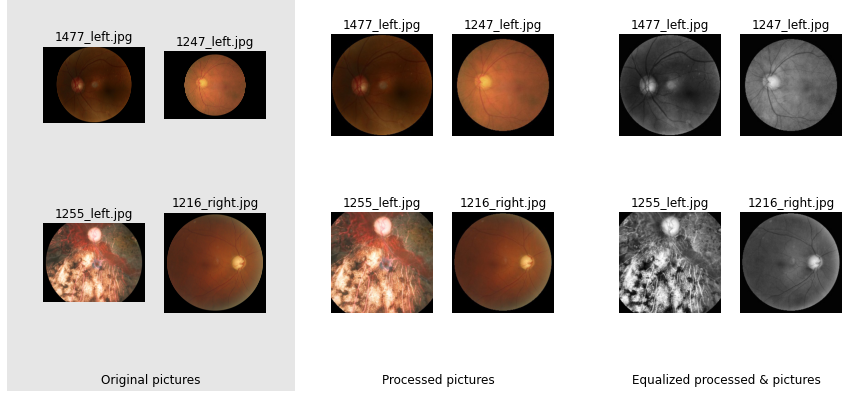

In [36]:
compare_images(df_G,title="\033[1m GLAUCOMA :\n\033[0m")

 MYOPIA :



IndexError: index 2 is out of bounds for axis 0 with size 2

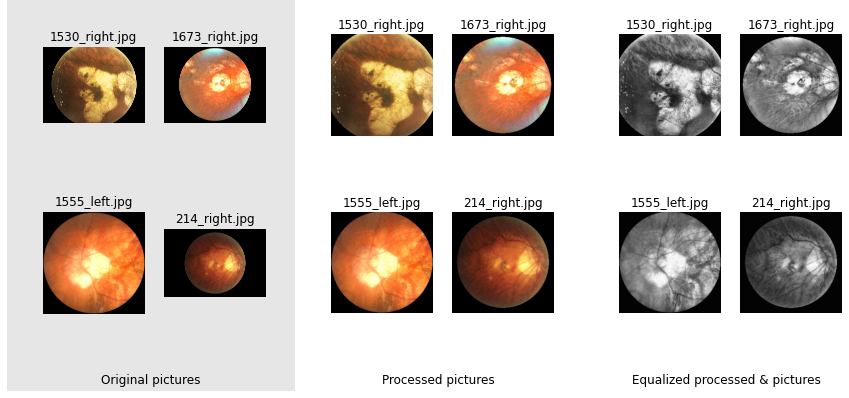

In [37]:
compare_images(df_M,title="\033[1m MYOPIA :\n\033[0m")